<a href="https://colab.research.google.com/github/Tarbris/Multiple-Style-comic-iamge-generation-based-on-GAN/blob/main/stylize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


# Multiple Style comic iamge generation based on real people picture
# 基于真实人物多种风格漫画生成研究方法

In [ ]:
#@title 初始化代码文件，下载必要的组件。
#@markdown Setup the project.
#!git clone https://github.com/mchong6/JoJoGAN.git
%cd MultipleComicGAN
!pip install tqdm gdown scipy lpips dlib opencv-python wandb
#!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb
from model import *
from e4e_projection import projection as e4e_projection

from google.colab import files
from copy import deepcopy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)



/content/drive/MyDrive/JoJoGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.2 MB/s eta

In [ ]:
#@title Download models
#@markdown You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits.
download_with_pydrive = True #@param {type:"boolean"}
device = 'cuda' #@param ['cuda', 'cpu']

#!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst



downloader = Downloader(download_with_pydrive)

'''downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')
downloader.download_file('arcane_caitlyn_preserve_color.pt')
downloader.download_file('arcane_jinx_preserve_color.pt')
downloader.download_file('jojo_preserve_color.pt')
downloader.download_file('jojo_yasuho_preserve_color.pt')
downloader.download_file('arcane_multi_preserve_color.pt')
downloader.download_file('disney_preserve_color.pt')
downloader.download_file('arcane_caitlyn.pt')
downloader.download_file('arcane_jinx.pt')
downloader.download_file('jojo.pt')'''
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)
generator2 = deepcopy(original_generator)
generator3 = deepcopy(original_generator)
generator4 = deepcopy(original_generator)
generator5 = deepcopy(original_generator)
generator6 = deepcopy(original_generator)


transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


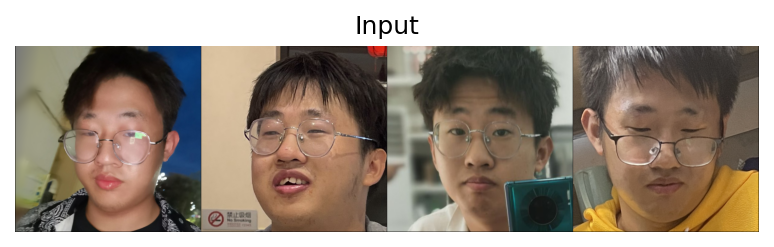

In [ ]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
face1 = 'mao1.JPG' #@param {type:"string"}
face2 = 'mao2.JPG' #@param {type:"string"}
face3 = 'mao3.JPG' #@param {type:"string"}
face4 = 'mao4.JPG' #@param {type:"string"}

filepath1 = f'test_input/{face1}'
filepath2 = f'test_input/{face2}'
filepath3 = f'test_input/{face3}'
filepath4 = f'test_input/{face4}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name1 = strip_path_extension(filepath1)+'.pt'
name2 = strip_path_extension(filepath2)+'.pt'
name3 = strip_path_extension(filepath3)+'.pt'
name4 = strip_path_extension(filepath4)+'.pt'


# aligns and crops face
aligned_face1 = align_face(filepath1)
aligned_face2 = align_face(filepath2)
aligned_face3 = align_face(filepath3)
aligned_face4 = align_face(filepath4)


# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w1 = e4e_projection(aligned_face1, name1, device).unsqueeze(0)
my_w2 = e4e_projection(aligned_face2, name2, device).unsqueeze(0)
my_w3 = e4e_projection(aligned_face3, name3, device).unsqueeze(0)
my_w4 = e4e_projection(aligned_face4, name4, device).unsqueeze(0)

face_input1 = transform(aligned_face1).unsqueeze(0).to(device)
face_input2 = transform(aligned_face2).unsqueeze(0).to(device)
face_input3 = transform(aligned_face3).unsqueeze(0).to(device)
face_input4 = transform(aligned_face4).unsqueeze(0).to(device)

input_face = torch.cat([face_input1, face_input2, face_input3, face_input4], 0)
display_image(utils.make_grid(input_face, normalize=True, ), title='Input')
#display_image(aligned_face1, title='Aligned face')
#display_image(aligned_face2, title='Aligned face')

# Use pretrained styles

/content/drive/MyDrive/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.2.1+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


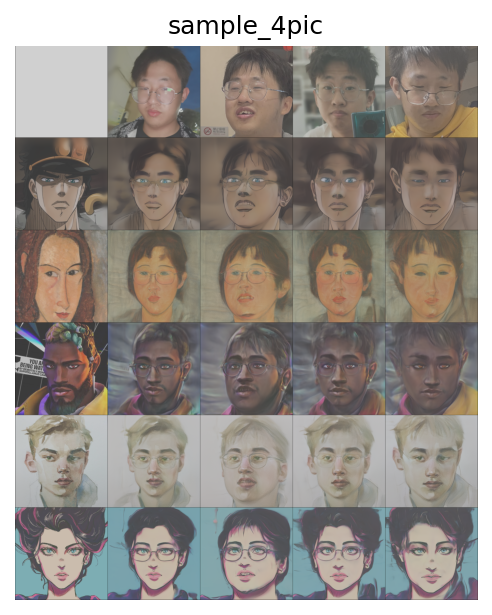

In [ ]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'jojo' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney', 'LOL', 'modig', 'water', 'yukako']

pretrained2 = 'modig' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney', 'LOL', 'modig', 'water', 'yukako']

pretrained3 = 'LOL' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney', 'LOL', 'modig', 'water', 'yukako']
pretrained4 = 'water' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney', 'LOL', 'modig', 'water', 'yukako']
pretrained5 = 'yukako' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney', 'LOL', 'modig', 'water', 'yukako']


#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = False #@param{type:"boolean"}
if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
    ckpt2 = f'{pretrained2}_preserve_color.pt'
    ckpt3 = f'{pretrained3}_preserve_color.pt'
    ckpt4 = f'{pretrained4}_preserve_color.pt'
    ckpt5 = f'{pretrained5}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'
    ckpt2 = f'{pretrained2}.pt'
    ckpt3 = f'{pretrained3}.pt'
    ckpt4 = f'{pretrained4}.pt'
    ckpt5 = f'{pretrained5}.pt'


# load base version if preserve_color version not available
'''try:
    downloader.download_file(ckpt)
    downloader.download_file(ckpt2)
    downloader.download_file(ckpt3)
    downloader.download_file(ckpt4)
    downloader.download_file(ckpt5)
except:
    ckpt = f'{pretrained}.pt'
    ckpt2 = f'{pretrained2}.pt'
    ckpt3 = f'{pretrained3}.pt'
    ckpt4 = f'{pretrained4}.pt'
    ckpt5 = f'{pretrained5}.pt'
    downloader.download_file(ckpt)
    downloader.download_file(ckpt2)
    downloader.download_file(ckpt3)
    downloader.download_file(ckpt4)
    downloader.download_file(ckpt5)'''

ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
ckpt2 = torch.load(os.path.join('models', ckpt2), map_location=lambda storage, loc: storage)
ckpt3 = torch.load(os.path.join('models', ckpt3), map_location=lambda storage, loc: storage)
ckpt4 = torch.load(os.path.join('models', ckpt4), map_location=lambda storage, loc: storage)
ckpt5 = torch.load(os.path.join('models', ckpt5), map_location=lambda storage, loc: storage)
#ckpt6 = torch.load("models/water.pt", map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)
generator2.load_state_dict(ckpt2["g"], strict=False)
generator3.load_state_dict(ckpt3["g"], strict=False)
generator4.load_state_dict(ckpt4["g"], strict=False)
generator5.load_state_dict(ckpt5["g"], strict=False)
#generator6.load_state_dict(ckpt6["g"], strict=False)

#@title Generate results
#n_sample =  6#@param {type:"number"}
#seed = 3000 #@param {type:"number"}

#torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    #z = torch.randn(n_sample, latent_dim, device=device)

    #original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    #sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    #original_my_sample = original_generator(my_w1, input_is_latent=True)
    my_sample1_1 = generator(my_w1, input_is_latent=True)
    my_sample1_2 = generator(my_w2, input_is_latent=True)
    my_sample1_3 = generator(my_w3, input_is_latent=True)
    my_sample1_4 = generator(my_w4, input_is_latent=True)
    my_sample2_1 = generator2(my_w1, input_is_latent=True)
    my_sample2_2 = generator2(my_w2, input_is_latent=True)
    my_sample2_3 = generator2(my_w3, input_is_latent=True)
    my_sample2_4 = generator2(my_w4, input_is_latent=True)
    my_sample3_1 = generator3(my_w1, input_is_latent=True)
    my_sample3_2 = generator3(my_w2, input_is_latent=True)
    my_sample3_3 = generator3(my_w3, input_is_latent=True)
    my_sample3_4 = generator3(my_w4, input_is_latent=True)
    my_sample4_1 = generator4(my_w1, input_is_latent=True)
    my_sample4_2 = generator4(my_w2, input_is_latent=True)
    my_sample4_3 = generator4(my_w3, input_is_latent=True)
    my_sample4_4 = generator4(my_w4, input_is_latent=True)
    my_sample5_1 = generator5(my_w1, input_is_latent=True)
    my_sample5_2 = generator5(my_w2, input_is_latent=True)
    my_sample5_3 = generator5(my_w3, input_is_latent=True)
    my_sample5_4 = generator5(my_w4, input_is_latent=True)
    #my_sample6 = generator6(my_w, input_is_latent=True)

# display reference images
'''
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
elif pretrained == 'sketch_multi':
    style_path = f'style_images_aligned/sketch.png'
else:
    style_path = f'style_images_aligned/{pretrained}.png'
'''
style_path = f'style_images_aligned/{pretrained}.png'
style_path2 = f'style_images_aligned/{pretrained2}.png'
style_path3 = f'style_images_aligned/{pretrained3}.png'
style_path4 = f'style_images_aligned/{pretrained4}.png'
style_path5 = f'style_images_aligned/{pretrained5}.png'
blank_path = f'style_images_aligned/blank.png'
#style_path6 = f'style_images_aligned/water.png'
blank_image = transform(Image.open(blank_path)).unsqueeze(0).to(device)
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
style_image2 = transform(Image.open(style_path2)).unsqueeze(0).to(device)
style_image3 = transform(Image.open(style_path3)).unsqueeze(0).to(device)
style_image4 = transform(Image.open(style_path4)).unsqueeze(0).to(device)
style_image5 = transform(Image.open(style_path5)).unsqueeze(0).to(device)
#style_image6 = transform(Image.open(style_path6)).unsqueeze(0).to(device)
ori_face1 = transform(aligned_face1).unsqueeze(0).to(device)
ori_face2 = transform(aligned_face2).unsqueeze(0).to(device)
ori_face3 = transform(aligned_face3).unsqueeze(0).to(device)
ori_face4 = transform(aligned_face4).unsqueeze(0).to(device)

#input = torch.cat([face], 0)
#display_image(utils.make_grid(input, normalize=True, ), title='Input')

#my_output = torch.cat([style_image, my_sample], 0)
#display_image(utils.make_grid(my_output, normalize=True, ), title='sample1')

#my_output2 = torch.cat([style_image2, my_sample2_2], 0)
#display_image(utils.make_grid(my_output2, normalize=True, ), title='sample2')

#my_output3 = torch.cat([style_image3, my_sample3], 0)
#display_image(utils.make_grid(my_output3, normalize=True, ), title='sample3')

#my_output4 = torch.cat([style_image4, my_sample4], 0)
#display_image(utils.make_grid(my_output4, normalize=True, ), title='sample4')

#my_output5 = torch.cat([style_image5, my_sample5], 0)
#display_image(utils.make_grid(my_output5, normalize=True, ), title='sample5')

my_output_4pic = torch.cat([blank_image, ori_face1, ori_face2, ori_face3, ori_face4, style_image, my_sample1_1, my_sample1_2, my_sample1_3, my_sample1_4, style_image2, my_sample2_1, my_sample2_2, my_sample2_3, my_sample2_4, style_image3, my_sample3_1, my_sample3_2, my_sample3_3, my_sample3_4, style_image4, my_sample4_1, my_sample4_2, my_sample4_3, my_sample4_4, style_image5, my_sample5_1, my_sample5_2, my_sample5_3, my_sample5_4], 0)
display_image(utils.make_grid(my_output_4pic, normalize=True, nrow=5), title='sample_4pic')

#my_output7 = torch.cat([style_image6, my_sample6], 0)
#display_image(utils.make_grid(my_output7, normalize=True, ), title='sample6')

#output = torch.cat([original_sample, sample], 0)
#display_image(utils.make_grid(output, normalize=True,  nrow=n_sample))

# Train with your own style images

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


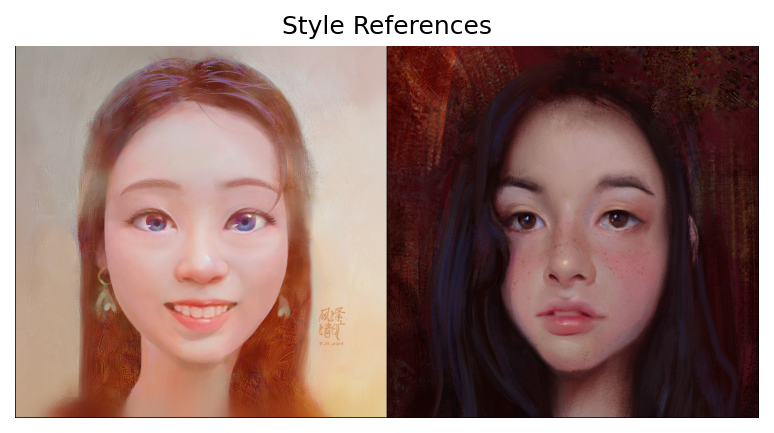

In [ ]:
#@markdown Upload your own style images into the style_images folder and type it into the field in the following format without the directory name. Upload multiple style images to do multi-shot image translation
names = [     'cute1.jpg', 'cute2.jpg'] #@param {type:"raw"}

targets = []
latents = []

for name in names:
    style_path = os.path.join('style_images', name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True, )
display_image(target_im, title='Style References')

In [ ]:
#@title Finetune StyleGAN
#@markdown alpha controls the strength of the style
alpha =  1.0 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha

#@markdown Tries to preserve color of original image by limiting family of allowable transformations. Set to false if you want to transfer color from reference image. This also leads to heavier stylization
name_model = "cute" #@param {type:"string"}
preserve_color = False #@param{type:"boolean"}
#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter = 3000 #@param {type:"number"}
#@markdown Log training on wandb and interval for image logging
use_wandb = True #@param {type:"boolean"}
log_interval = 50 #@param {type:"number"}

if preserve_color:
  path_save = f'models/{name_model}_preserve_color.pt'
else:
  path_save = f'models/{name_model}.pt'

if use_wandb:
    wandb.init(project="JoJoGAN")
    config = wandb.config
    config.num_iter = num_iter
    config.preserve_color = preserve_color
    wandb.log(
    {"Style reference": [wandb.Image(transforms.ToPILImage()(target_im))]},
    step=0)

# load discriminator for perceptual loss
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)

    with torch.no_grad():
        real_feat = discriminator(targets)
    fake_feat = discriminator(img)

    loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)

    if use_wandb:
        wandb.log({"loss": loss}, step=idx)
        if idx % log_interval == 0:
            generator.eval()
            my_sample = generator(my_w1, input_is_latent=True)
            generator.train()
            my_sample = transforms.ToPILImage()(utils.make_grid(my_sample, normalize=True, ))
            wandb.log(
            {"Current stylization": [wandb.Image(my_sample)]},
            step=idx)

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

torch.save({"g": generator.state_dict()}, path_save)
print("Saved")

loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss,0.05491


  0%|          | 0/3000 [00:00<?, ?it/s]/content/drive/MyDrive/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.2.1+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100%|██████████| 3000/3000 [42:10<00:00,  1.19it/s]


Saved


/content/drive/MyDrive/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.2.1+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


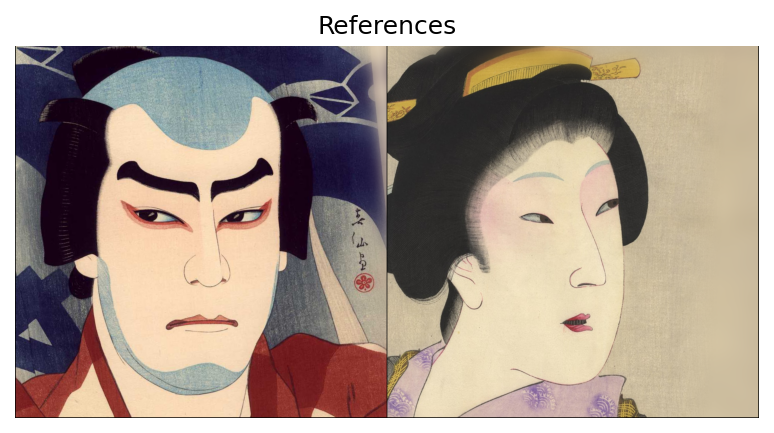

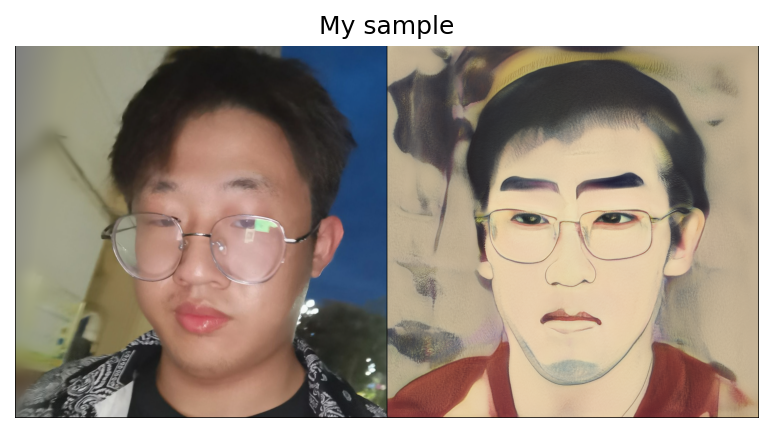

In [ ]:
#@title Generate results
#n_sample =  5#@param {type:"number"}
#seed = 3000 #@param {type:"number"}

#torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    #z = torch.randn(n_sample, latent_dim, device=device)

    #original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    #sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w1, input_is_latent=True)
    my_sample = generator(my_w1, input_is_latent=True)

# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)

face = transform(aligned_face1).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, ), title='References')
#utils.save_image(original_sample,"1.png")
my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, ), title='My sample')

#output = torch.cat([original_sample, sample], 0)

#display_image(utils.make_grid(output, normalize=True, nrow=n_sample), title='Random samples')